# Сравнение трудоёмкости алгоритмов поисков на графах
Выполнил Безлепский Александр Дмитриевич, гр. 5
>* **DFS** - Depth-First Search - Поиск в глубину**
>* **BFS** - Breadth-First Search - Поиск в ширину**

https://arxiv.org/abs/2111.07345

Другими словами, измерение безразмерной величины $\cfrac{\Theta_{DFS}}{\Theta_{BFS}} = \Large\psi$

> В качестве среды разработки используем интерактивные блокноты [Jupyter<base target="_blank">](https://jupyter.org/), код написан на языке [Julia <base target="_blank">](https://julialang.org/) и выполнен паралленьно на 16 ядрах процессора.

## Что будем делать?

Генерация случайного графа оказалась нетривиальной задачей. Чтобы как-то ограничить исследование, предлагаю следующие шаги:
1. Напишем алгоритмы поиска;
2. Разберёмся с используемыми инструментами;
3. Формализуем алгоритмы генерации графов и проведём на них вычислительные эксперименты;

>### Отступление
>Человек ленив. Там, где можно немного упростить себе жизнь, это будет сделано. С этой целью было создано множество высокоуровневых языков программирования, Julia - один из таких. В её экосистеме написано множество библиотек, где описываются графы и вводятся распространённые алгоритмы на них.
>
>Человек ленив, студент - тоже человек, но некотоыре вещи стоит написать самому: используя готовые алгоритмы обхода и пытаясь подстроить их под свои нужды можно набить немало шишек. В библиотеке `Graphs.jl` именно поиски с подсчётом шагов и списком посещённых узлов отсутствуют, вместо них тут различные алгоритмы используют генераторы орграфов. В попытках подстроить эти генераторы под себя студент теряет время и удаляется от сути предмета в сторону хакинга и написания костылей.
## Содержание:
1. [Алгоритмы поиска](#1.-Алгоритмы-поиска)
2. [Инструменты](#2.-Инструменты)
3. [Вычислительные эксперименты](#3.-Эксперименты)
    1. [Dorogovtsev and Mendes](#3.1-Dorogovtsev-and-Mendes)
    2. [Erdős–Rényi](#3.2-Erdős-Rényi)
    3. [Регулярный граф](#3.3-Регулярный-граф)
    4. [Однородные деревья](#3.4-Однородные-(uniform)-деревья)
    5. [Бинарные деревья](#3.5-Бинарные-деревья)
4. [Заключение](#4.-Заключение)
---
## 1. Алгоритмы поиска
Сначала напишем сами алгоритмы поиска в ширину и глубину. По сути своей, это один и тот же алгоритм, реализованный на двух разных структурах данных: **стек** для поиска в глубину и **очередь** для поиска в ширину. И то и другое нам отлично заменит стандартный Vector:

In [ ]:
# Вернёт пройденный маршрут
function findpath(p!, graph, a, b)
    visited = falses(length(graph.fadjlist))
    parent = fill(-1, length(graph.fadjlist))
    dataStructure = Int64[]
    push!(dataStructure, a)
    visited[a] = true
    while !isempty(dataStructure)
        curr_node = p!(dataStructure)             # <--- Сюда подставится нужная функция
        for neighbor in graph.fadjlist[curr_node]
            if !visited[neighbor]
                visited[neighbor] = true
                parent[neighbor] = curr_node
                push!(dataStructure, neighbor)
            end
        end
        if curr_node == b
            path = [b]
            while path[end] != a
                push!(path, parent[path[end]])
            end
            return reverse(path)
        end
    end
    return Int64[]
end

# Подставляя в 9-ю строчку выше нужную функцию удаления
# последнего или первого элемента добиваемся желаемого
dfs_path(graph, a, b) = findpath(pop!,      graph, a, b) 
bfs_path(graph, a, b) = findpath(popfirst!, graph, a, b)

In [1]:
# Перепишем для подсчёта количества шагов (уменьшим аллокации => увеличим быстродействие)
function countsteps(p!, graph, a, b)
    visited = falses(length(graph.fadjlist))
    dataStructure = Int64[]
    push!(dataStructure, a)
    visited[a] = true
    
    steps = -1
    while !isempty(dataStructure)
        curr_node = p!(dataStructure)
        steps += 1
        for neighbor in graph.fadjlist[curr_node]
            if !visited[neighbor]
                visited[neighbor] = true
                push!(dataStructure, neighbor)
            end
        end
        if curr_node == b
            return steps
        end
    end
    return steps
end

dfs_steps(graph, a, b) = countsteps(pop!,      graph, a, b) 
bfs_steps(graph, a, b) = countsteps(popfirst!, graph, a, b);

Примечание: в ячейке выше используются два эквивалентных синтаксиса задания функции.

## 2. Инструменты
[К содержанию](#Содержание:)

Ниже приведены библиотеки языка Julia, которые нам понадобятся в процессе работы:
* Библиотека для генерации различных графов
* Библиотеки рисования схем графов и графиков для отрисовки статистики

In [2]:
using Graphs
using GraphPlot
using Colors
using ColorSchemes
using Plots
using PlotThemes
using ThreadsX
using ProgressMeter
using LaTeXStrings;

### Небольшой пример
Простенький демонстрационный граф, который предоставляет сама библиотека 

In [43]:
# Обернём библиотечную функцию для упрощения дальшейших вызовов:
function plot_graph(graph)
    # Все аргументы рисовалки более-менее самообъясняющие:
    gplot(   
        graph,
        nodefillc = "black",
        nodelabel = 1:nv(graph),
        nodelabelc = "white",
        edgestrokec = "darkgray",
    )
end;

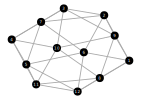

In [44]:
# Здесь `:icosahedral` это значение-лейбл, служащее аргументом функции отрисовки
sample = smallgraph(:icosahedral)

plot_graph(sample)

In [ ]:
dfs_steps(sample, 1, 1)

Получим списки посещённых вершин и их длины (без учёта стартовых):

In [ ]:
@show dfs_steps(sample, 1, 10)
dfs_path(sample, 1, 10)

In [ ]:
@show bfs_steps(sample, 5, 10) + bfs_steps(sample, 10, 5)
@show dfs_steps(sample, 5, 10) + dfs_steps(sample, 10, 5)
bfs_path(sample, 1, 10)

Обернём функции выше в ещё одну - которая и будет возвращать искомую величину $\Large\psi$ для всего графа:

In [3]:
# Средняя трудоёмкость для всего графа по каждой паре вершин туда и назад
function ψᵢ_sum_biDir(graph::SimpleGraph)
    ratio = 0.0
    n = 0
    for i in 1:nv(graph)
        for j in 1+i:nv(graph)
            breadth_steps = bfs_steps(graph, i, j)
            if breadth_steps <= 0
                continue
            else
                ratio += (breadth_steps + bfs_steps(graph, j, i)) / (dfs_steps(graph, i, j) + dfs_steps(graph, j, i))
                n += 1
            end
        end
    end
    return ratio / n
end

ψᵢ_sum_biDir (generic function with 1 method)

In [51]:
# Средняя трудоёмкость для всего графа по каждой паре вершин туда и назад
function phi(graph::SimpleGraph)
    ratio = 0.0
    n = 0
    for i in 1:nv(graph)
        for j in 1:nv(graph)
            breadth_steps = bfs_steps(graph, i, j)
            if breadth_steps <= 0
                continue
            else
                ratio += dfs_steps(graph, i, j) / breadth_steps
                n += 1
            end
        end
    end
    return ratio / n
end

phi (generic function with 1 method)

In [50]:
asdqwewert(sample)

2.230718439809348

Покажем работу алгоритма на графе из примера:

In [ ]:
@time @show ψᵢ_sum_biDir(sample)

Отлично, первый результат получен! Конечно, можно и дальше оптимизировать алгоритм, но, в угоду простоте прототипирования, мы опустим сейчас какие-либо оптимизации, даже не будем аннотировать функции именами типов. Несмотря на это Julia может быть действительно эффективной, приближаясь по производительности к таким компилируемым языкам как C и Fortran. 

---
Перейдём, наконец, к объявленному вычислительному эксперименту. В пакете [Graphs.jl <base target="_blank">](https://juliagraphs.org/Graphs.jl/dev/) есть несколько алгоритмов генерации графов. Наперёд оценить, несколько один предпочтительнее другого не представляется возможным, так что попробуем несколько...

## 3. Эксперименты

[К содержанию](#Содержание:)

### 3.1 [Dorogovtsev and Mendes<base target="_blank">](https://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/)
Вот как он описан в документации пакета:

>`dorogovtsev_mendes(n)`
>
>Generate a random `n` vertex graph by the Dorogovtsev-Mendes method (with `n ≥ 3`).
>
>The Dorogovtsev-Mendes process begins with a triangle graph and inserts `n-3` additional vertices. Each time a vertex is added, a random edge is selected and the new vertex is connected to the two endpoints of the chosen edge. This creates graphs with many triangles and a high local clustering coefficient.
>
> <...>
>### References
>
  >* http://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/
  >* https://arxiv.org/pdf/cond-mat/0106144.pdf#page=24

Как видим, этот генератор имеет всего один параметр - количество узлов. Посмотрим, что он генерирует:

In [ ]:
dmPlot(g) = gplot(g, nodefillc = "#546ea1", edgestrokec = "darkgray");

In [ ]:
dm1 = dorogovtsev_mendes(20)
@time @show ψᵢ_sum_biDir(dm1)
dmPlot(dm1)

In [ ]:
dm2 = dorogovtsev_mendes(50)
@time @show ψᵢ_sum_biDir(dm2)
dmPlot(dm2)

In [ ]:
dm3 = dorogovtsev_mendes(500)
@time @show ψᵢ_sum_biDir(dm3)
dmPlot(dm3)

Замечу, что во всех достаточно больших сгенерированных графах (выше лишь несколько примеров) есть вершины с относительно высокой степенью (назовём их `центры`). Похоже, они - естественное следствие работы генератора: чем больше рёбер смежно с вершиной, тем вероятнее, что при следующем шаге генератора, на одну из них выпадет стать смежной новой вершине, а значит, степень такого `центра` снова повысится.

In [52]:
function d_m_tests(nspace, repeats)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1 # Количество вершин в обратном порядке
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(nspace[i]) # новый случайный граф на каждом шаге
            av[j] = phi(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [53]:
logspace(
    start::Real,
    stop::Real,
    len=50,
    base=10
    ) = base.^range(start, stop, len)

logspace(
    T::DataType,
    start::Real,
    stop::Real,
    len=50,
    base=10
    ) = logspace(start, stop, len, base) .|> ceil .|> T;

In [57]:
nspace_dm = logspace(Int, 0.85, 2.3, 30);

dmt1 = d_m_tests(nspace_dm, 1)
dmt2 = d_m_tests(nspace_dm, 10)
dmt3 = d_m_tests(nspace_dm, 50)
dmt4 = d_m_tests(nspace_dm, 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


30-element Vector{Float64}:
 1.7493469715118408
 1.7515535354614258
 1.8011950254440308
 1.845499873161316
 1.9186800718307495
 1.9481087923049927
 2.0005640983581543
 2.033459424972534
 2.0697951316833496
 2.1092073917388916
 2.1657094955444336
 2.208190679550171
 2.242635488510132
 ⋮
 2.475137710571289
 2.5039429664611816
 2.533059597015381
 2.563857316970825
 2.6015055179595947
 2.6257219314575195
 2.652722120285034
 2.6890366077423096
 2.737999200820923
 2.765979051589966
 2.7760121822357178
 2.800894260406494

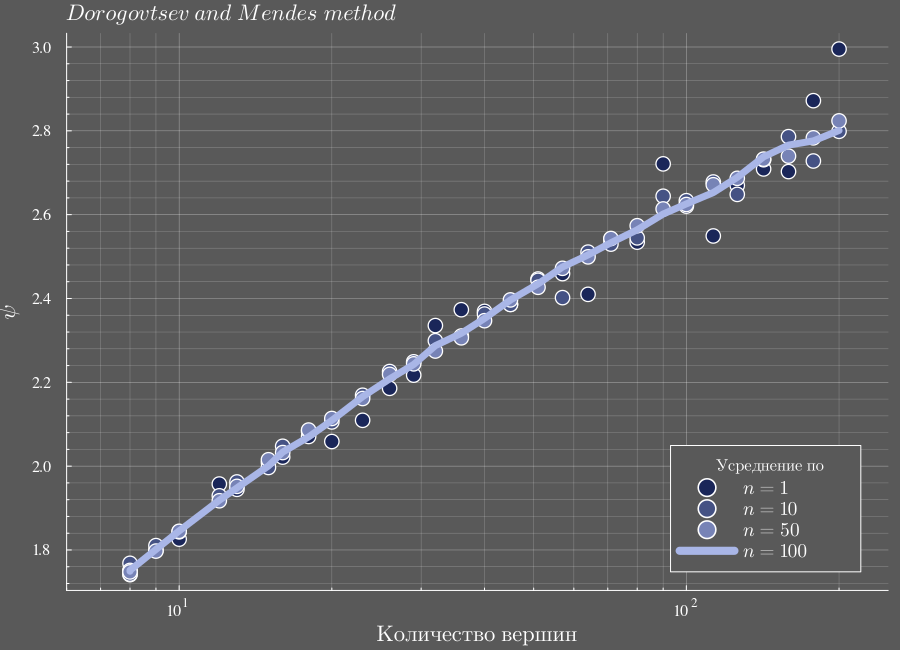

In [65]:
p1 = scatter(nspace_dm, dmt1,
    title = L"Dorogovtsev\ and\ Mendes\ method",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 13,
    label = L"n = 1",
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log),
    xlims = (6, 250),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = L"\psi",
#     ylims = (1.08, 1.5),
    markersize = 8,
    background_color = :grey35,
    palette = ColorSchemes.oleron10[1:end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    markerstrokewidth = 1,
    
    labelfontsize = 15,
    leg_title = L"Усреднение\ по"
    )
scatter!(nspace_dm, dmt2, label = L"n = 10", markersize = 8, markerstrokewidth = 1)
scatter!(   nspace_dm, dmt3, label = L"n = 50", markersize = 8, markerstrokewidth = 1)
plot!(   nspace_dm, dmt4, label = L"n = 100",linewidth = 7)


Условные обозначения здесь и ниже:
* $\Large\psi$ -- искомая метрика
* $\large N$ -- количество вершин в графе
* $\large n$ -- количество запусков алгоритма для усреднения
* $\large p$ -- вероятность в модели Эрдёша-Реньи
* $\large k$ -- степень вершин в регулярном графе

In [66]:
savefig(p1, "plots/DorogovtsevMendes_1.svg");

In [67]:
nspace_dm_ext = logspace(Int, 2, 10, 30, 2);
dmt6 = d_m_tests(nspace_dm_ext, 50);

Progress: 100%|█████████████████████████████████████████| Time: 0:10:34


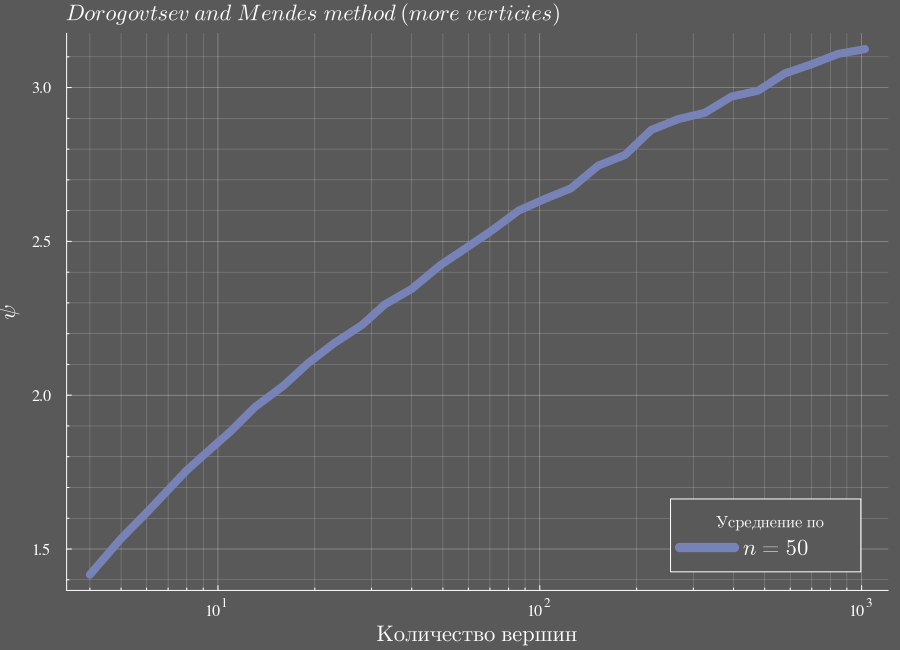

In [71]:
# theme(:vibrant)
p2 = plot(nspace_dm_ext, dmt6,
    title = L"Dorogovtsev\ and\ Mendes\ method\ (more\ verticies)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 15,
    label = L"n = 50",
    
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log10),
#     xlims = (3, 1.6e3),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = L"\psi",
#     ylims = (1.15, 1.45),
    markersize = 8,
    linewidth = 8,
    
    background_color = :grey35,
    color = ColorSchemes.oleron10[3],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    labelfontsize = 15,
    
    markerstrokewidth = 0,
    leg_title = L"Усреднение\ по"
)

In [72]:
savefig(p2, "plots/DorogovtsevMendes_2.svg");

### 3.2 [Erdős-Rényi<base target="_blank">](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)

[К содержанию](#Содержание:)

Этот алгоритм создаёт `n` вершин и пробрасывает между всеми парами установленную вероятность `p` чтобы соединить их ребром.

Посмотрим на его работу:

In [ ]:
erPlot(g) = gplot(g, nodefillc = "Orange", edgestrokec = "darkgray");

In [ ]:
er1 = erdos_renyi(6, 1.)
@time @show ψᵢ_sum_biDir(er1)
erPlot(er1)

In [ ]:
er2 = erdos_renyi(6, 0.5)
@time @show ψᵢ_sum_biDir(er2)
erPlot(er2)

In [ ]:
er3 = erdos_renyi(100, 0.02)
@time @show ψᵢ_sum_biDir(er3)
erPlot(er3)

In [ ]:
er4 = erdos_renyi(300, 0.005)
@time @show ψᵢ_sum_biDir(er4)
erPlot(er4)

In [150]:
function e_r_tests(nspace, repeats, p)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = erdos_renyi(nspace[i], p)
            av[j] = phi(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [151]:
repeats_er = 100
nspace_er = logspace(Int, 0.8, 2.4, 40); # 3:5:200
ert0 = e_r_tests(nspace_er, repeats_er, 0.01)
ert1 = e_r_tests(nspace_er, repeats_er, 0.02)
ert2 = e_r_tests(nspace_er, repeats_er, 0.05)
ert3 = e_r_tests(nspace_er, repeats_er, 0.1)
ert4 = e_r_tests(nspace_er, repeats_er, 0.2)
ert5 = e_r_tests(nspace_er, repeats_er, 0.3);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35
Progress: 100%|█████████████████████████████████████████| Time: 0:01:52
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


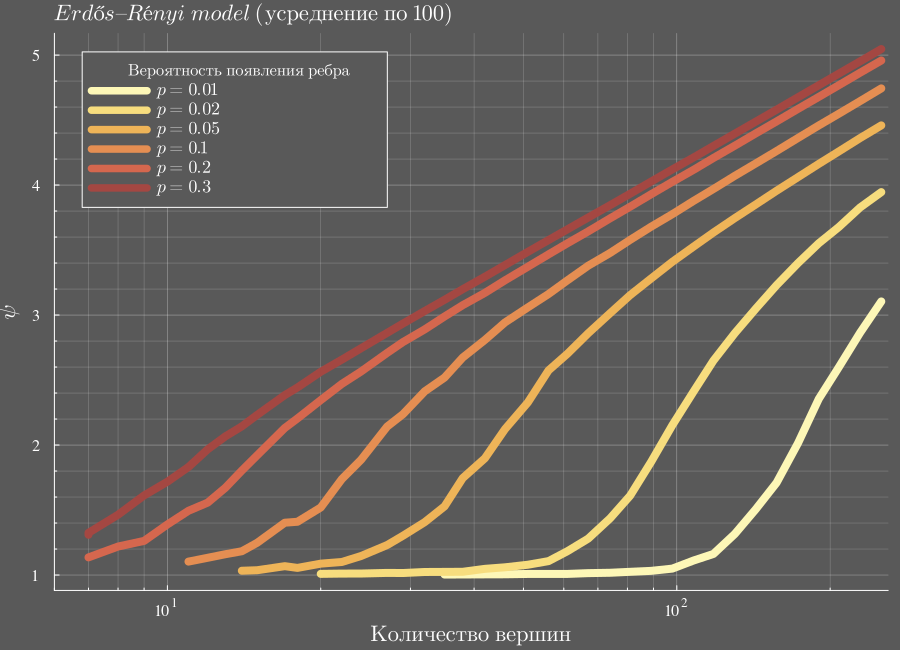

In [171]:
p3 = plot(nspace_er, ert0,
    title = L"Erdős–Rényi\ model\ (усреднение\ по\ 100)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topleft,
    legendfontsize = 12,
    label = L"p = 0.01",
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log, (6, 260)),
#     ylims = (1, 10),
    yaxis = L"\psi",
    linewidth = 8,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    palette = ColorSchemes.lajolla25[2:3:end],
    background_color = :grey35,
    leg_title = L"Вероятность\ появления\ ребра",
    
    labelfontsize = 15,
    
    )

plot!(nspace_er, ert1, label = L"p = 0.02",linewidth = 8)
plot!(nspace_er, ert2, label = L"p = 0.05",linewidth = 8)
plot!(nspace_er, ert3, label = L"p = 0.1",linewidth = 8)
plot!(nspace_er, ert4, label = L"p = 0.2",linewidth = 8)
plot!(nspace_er, ert5, label = L"p = 0.3",linewidth = 8)

In [182]:
savefig(p3, "plots/ErdosRenyi_1.svg");

In [154]:
function e_r_tests_prob(nspace, repeats, pspace)
    n = length(pspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for p in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = erdos_renyi(nspace, pspace[p])
            av[j] = phi(g)
        end
        results[p] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [155]:
repeats = 10
pspace_er = 0.01:0.02:1.0#logspace(-2.5, 0, 100)

ert6 = e_r_tests_prob(50, repeats, pspace_er)
ert7 = e_r_tests_prob(75, repeats, pspace_er)
ert8 = e_r_tests_prob(100, repeats, pspace_er)
ert9 = e_r_tests_prob(125, repeats, pspace_er)
ert10 = e_r_tests_prob(150, repeats, pspace_er)
ert11 = e_r_tests_prob(175, repeats, pspace_er);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


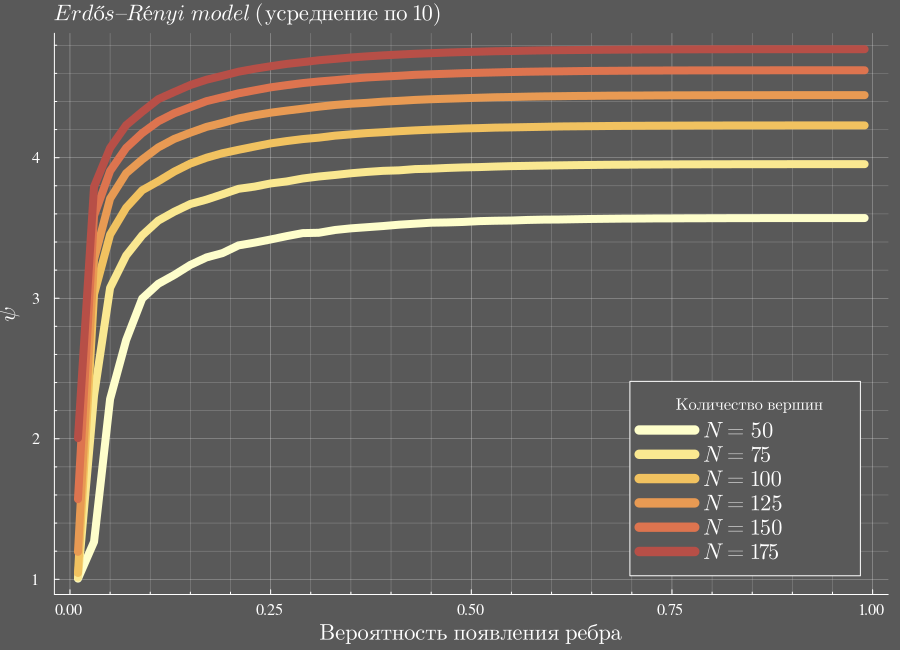

In [180]:
p4 = plot(pspace_er, ert6,
    title = L"Erdős–Rényi\ model\ (усреднение\ по\ 10)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 15,
    label = L"N = 50",
    size = (900, 650),
    xaxis = (L"Вероятность\ появления\ ребра"),
    yaxis = L"\psi",
    linewidth = 8,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    palette = ColorSchemes.lajolla25[1:3:end],
    background_color = :grey35,
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    leg_title = L"Количество\ вершин",
    labelfontsize = 15,
    )

plot!(pspace_er, ert7, label = L"N = 75",linewidth = 8)
plot!(pspace_er, ert8, label = L"N = 100",linewidth = 8)
plot!(pspace_er, ert9, label = L"N = 125",linewidth = 8)
plot!(pspace_er, ert10, label = L"N = 150",linewidth = 8)
plot!(pspace_er, ert11, label = L"N = 175",linewidth = 8)

In [181]:
savefig(p4, "plots/ErdosRenyi_2.svg");

Видим, что не все сгенерированные графы оказались полносвязными. Именно для этого случая в нашей функции есть фильтрация расстояний между вершинами разных компонент связности.

### 3.3 [Регулярный граф<base target="_blank">](https://en.wikipedia.org/wiki/Regular_graph)

[К содержанию](#Содержание:)

Случайный, с одинаковой степенью каждой вершины. Может оказаться не односвязным.

In [ ]:
rgPlot(g) = gplot(g, nodefillc = "#c368ab", edgestrokec = "darkgray");

In [ ]:
rg1 = random_regular_graph(20, 2)
@time @show ψᵢ_sum(rg1)
rgPlot(rg1)

In [ ]:
rg2 = random_regular_graph(12, 5)
@time @show ψᵢ_sum(rg2)
rgPlot(rg2)

In [ ]:
rg3 = random_regular_graph(50, 3)
@time @show ψᵢ_sum(rg3)
rgPlot(rg3)

In [ ]:
rg4 = random_regular_graph(20, 10)
@time @show ψᵢ_sum(rg4)
rgPlot(rg4)

In [158]:
function r_g_tests(nspace, repeats, k)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = random_regular_graph(nspace[i], k)
            av[j] = phi(g)
        end
        results[i] = sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [159]:
repeats = 100
lsp = 8:5:200#logspace(Int, 0.9, 2.7, 50)
nspace_rg2 = filter(isodd, lsp)
nspace_rg3 = filter(iseven,lsp)
nspace_rg4 = filter(isodd, lsp)
nspace_rg5 = filter(iseven,lsp)
nspace_rg6 = filter(isodd, lsp)



rgt2 = r_g_tests(nspace_rg2, repeats, 2)
rgt3 = r_g_tests(nspace_rg3, repeats, 3)
rgt4 = r_g_tests(nspace_rg4, repeats, 4)
rgt5 = r_g_tests(nspace_rg5, repeats, 5)
rgt6 = r_g_tests(nspace_rg6, repeats, 6);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


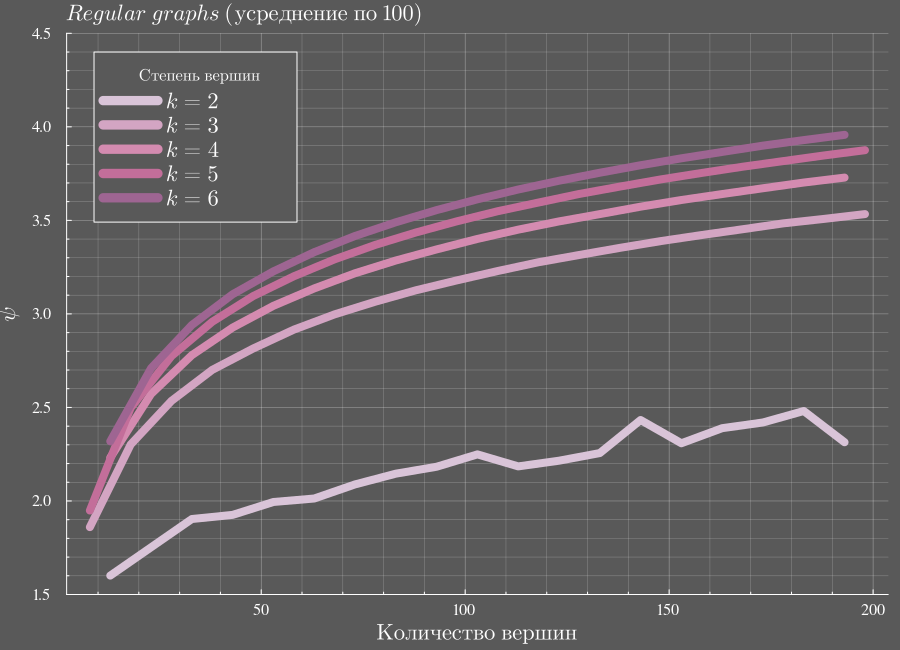

In [184]:
p5 = plot(nspace_rg2, rgt2,
    title = L"Regular\ graphs\ (усреднение\ по\ 100)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topleft,
    legendfontsize = 15,
    label = L"k = 2",
    size = (900, 650),
    xaxis = (L"Количество\ вершин"),
    yaxis = (L"\psi", (1.5, 4.5)),
    linewidth = 8,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    palette = ColorSchemes.acton25[end-3:-3:1],
    background_color = :grey35,
    leg_title = L"Степень\ вершин",
    labelfontsize = 15,
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    )

plot!(nspace_rg3, rgt3, label = L"k = 3",linewidth = 8)
plot!(nspace_rg4, rgt4, label = L"k = 4",linewidth = 8)
plot!(nspace_rg5, rgt5, label = L"k = 5",linewidth = 8)
plot!(nspace_rg6, rgt6, label = L"k = 6",linewidth = 8)

In [186]:
savefig(p5, "plots/Regular2-6.svg");

Я упускаю много ещё разновидностей графов, но не могу обойти стороной деревья.
### 3.4 [Однородные (uniform) деревья  <base target="_blank">](https://en.wikipedia.org/wiki/Uniform_tree)

[К содержанию](#Содержание:)

Для деревьев средняя эффективность алгоритмов поиска одинаковая, так что ниже графиков нет. 

In [ ]:
# Средняя трудоёмкость для всего графа по каждой паре вершин туда и назад
# function ψᵢ_sum_trees(graph::SimpleGraph)
#     breadth = depth = 0
#     for i in 1:nv(graph)
#         for j in 1:nv(graph)
#             breadth_steps = bfs_steps(graph, i, j)
#             if breadth_steps <= 0
#                 continue
#             end
#             breadth += breadth_steps
#             depth += dfs_steps(graph, i, j)
#         end
#     end
#     return depth/breadth
# end

In [ ]:
utPlot(g) = gplot(g, nodefillc = RGB(0.3,0.85,0.3), edgestrokec = "darkgray");

In [ ]:
t1 = uniform_tree(20)
@time @show ψᵢ_sum_biDir(t1)
utPlot(t1)

In [ ]:
t2 = uniform_tree(200)
@time @show ψᵢ_sum_biDir(t2)
utPlot(t2)

In [162]:
function trees_tests(nspace, repeats)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1 # Количество вершин в обратном порядке
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats # Количество повторений для усреднения
            g = uniform_tree(nspace[i]) # новый случайный граф на каждом шаге
            av[j] = phi(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [163]:
nspace_utree = logspace(Int, 0.85, 2.3, 30);

utree1 = trees_tests(nspace_utree, 10)
utree2 = trees_tests(nspace_utree, 50)
utree3 = trees_tests(nspace_utree, 100)
utree4 = trees_tests(nspace_utree, 200);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


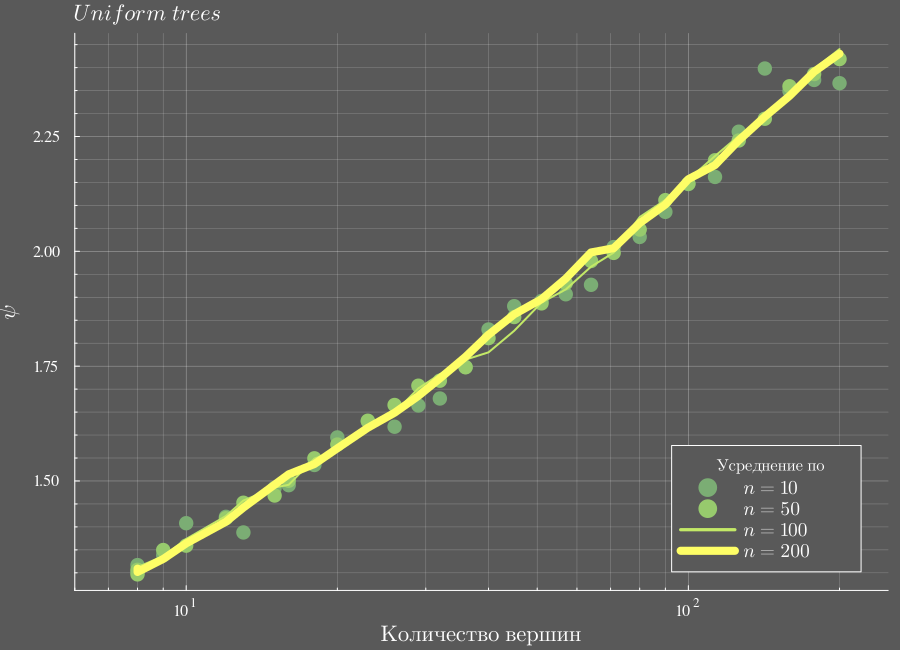

In [188]:
p6 = scatter(nspace_utree, utree1,
    title = L"Uniform\ trees",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 13,
    label = L"n = 10",
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log),
    xlims = (6, 250),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = L"\psi",
#     ylims = (1.08, 1.5),
    markersize = 8,
    background_color = :grey35,
    palette = ColorSchemes.imola10[end-3:end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    markerstrokewidth = 0,
    
    labelfontsize = 15,
    leg_title = L"Усреднение\ по"
    )
scatter!(nspace_utree, utree2, label = L"n = 50", markersize = 8, markerstrokewidth = 0)
plot!(   nspace_utree, utree3, label = L"n = 100", linewidth = 2)
plot!(   nspace_utree, utree4, label = L"n = 200", linewidth = 8)

In [165]:
savefig(p6, "plots/Utrees.svg");

In [166]:
nspace_utree_ext = logspace(Int, 1, 3, 27);
utree6 = trees_tests(nspace_utree_ext, 40);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:39


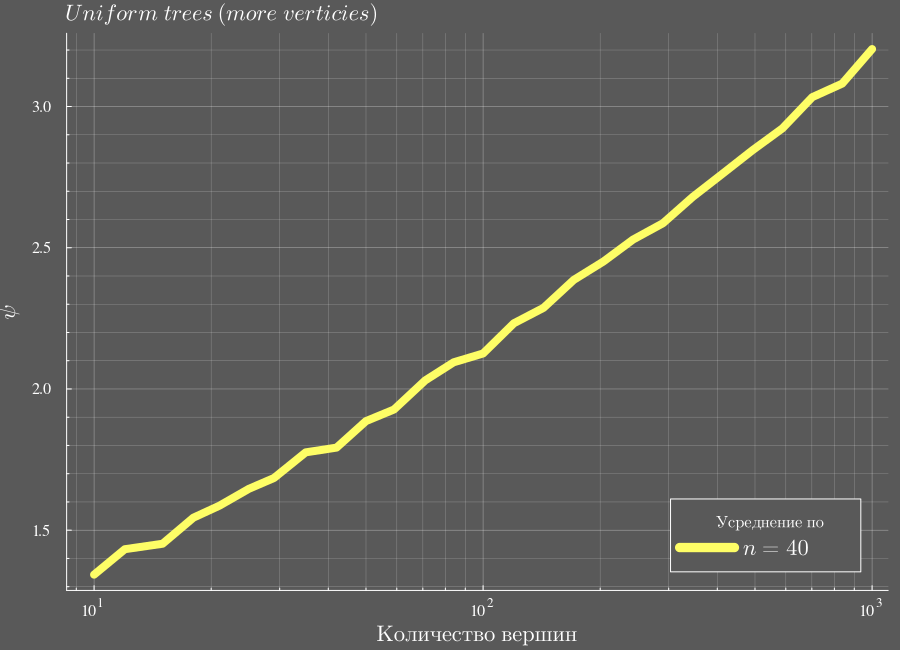

In [192]:
p7 = plot(nspace_utree_ext, utree6,
    title = L"Uniform\ trees\ (more\ verticies)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 15,
    label = L"n = 40",
    
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log10, (8.5, 1100)),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = L"\psi",
    markersize = 8,
    linewidth = 8,
    
    background_color = :grey35,
    color = ColorSchemes.imola10[end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    labelfontsize = 15,
    
    markerstrokewidth = 0,
    leg_title = L"Усреднение\ по"
)

In [193]:
savefig(p7, "plots/Utrees_ext.svg");

### 3.5 Бинарные деревья

[К содержанию](#Содержание:)

In [ ]:
btPlot(g) = gplot(g, nodefillc = RGB(0.6,0.7,0.6), edgestrokec = "darkgray", nodelabel = 1:nv(g));

In [ ]:
bt1 = binary_tree(4)
@time @show ψᵢ_sum_trees(bt1)
btPlot(bt1)

In [ ]:
bt2 = binary_tree(6)
@time @show ψᵢ_sum_trees(bt2)
btPlot(bt2)

In [195]:
function b_trees_tests(nspace, repeats)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1 # Количество вершин в обратном порядке
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats # Количество повторений для усреднения
            g = binary_tree(nspace[i]) # новый случайный граф на каждом шаге
            av[j] = phi(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [142]:
nspace_btr_R = 2:13
btr_fromroot1 = [btree_fromroot(binary_tree(n)) for n in nspace_btr_R];

In [216]:
btr1 = b_trees_tests(2:10, 1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


9-element Vector{Float64}:
 1.0833333730697632
 1.1480158567428589
 1.1658544540405273
 1.1773825883865356
 1.179233431816101
 1.1839486360549927
 1.1886135339736938
 1.1962265968322754
 1.2038718461990356

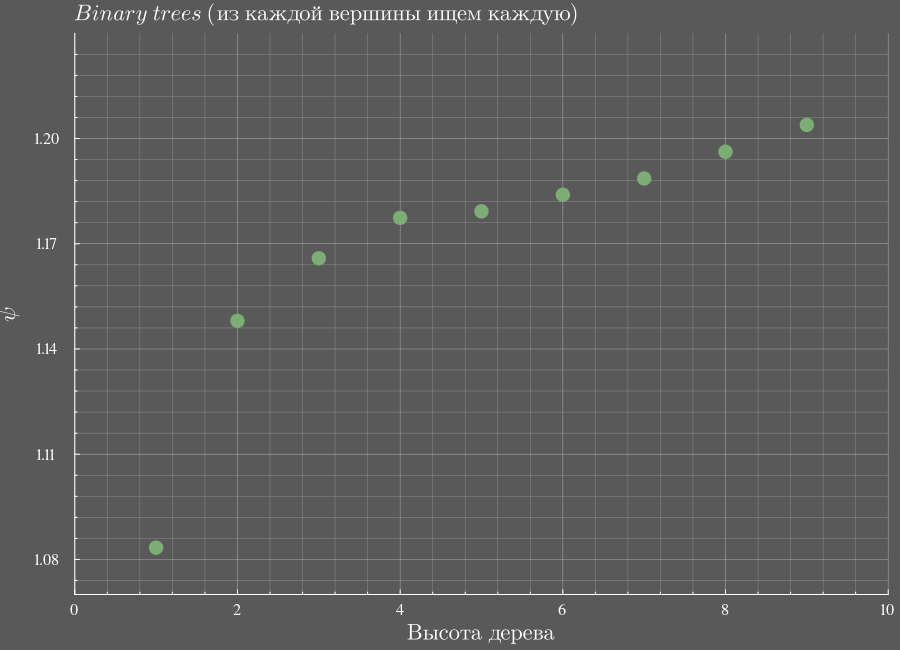

In [233]:
p8 = scatter(1:9, btr1,
    title = L"Binary\ trees\ (из\ каждой\ вершины\ ищем\ каждую)",
    titlepos = :left,
    titlefontsize = 15,
    legend = false,
    legendfontsize = 13,
    label = L"n = 10",
    size = (900, 650),
    xaxis = (L"Высота\ дерева", (0, 10)),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = (L"\psi", (1.07, 1.23)),
    markersize = 8,
    background_color = :grey35,
    palette = ColorSchemes.imola10[end-3:end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    markerstrokewidth = 0,
    
    labelfontsize = 15,
)

In [257]:
savefig(p8, "plots/Btrees_1.svg");

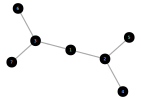

In [234]:
binary_tree(3) |> plot_graph

In [254]:
function findLeaf_fromroot(n)
    graph = binary_tree(n)
    ratio = 0.0
    for i in 2^(n-1):2^n-1
        ratio += dfs_steps(graph, 1, i) / bfs_steps(graph, 1, i)
    end
    return ratio / (2^(n-1))
end

findLeaf_fromroot (generic function with 2 methods)

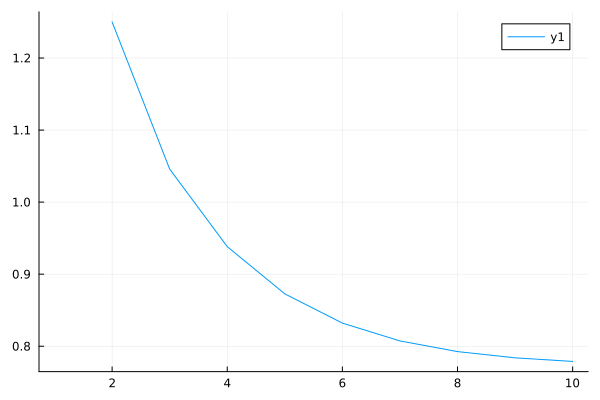

In [256]:
1:10 .|> findLeaf_fromroot |> plot

In [13]:
nspace_btree = 2:10;

btree1 = b_trees_tests(nspace_btree, 1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


9-element Vector{Float64}:
 1.0555555820465088
 1.1030234098434448
 1.0938712358474731
 1.0953645706176758
 1.0960849523544312
 1.0994625091552734
 1.102378249168396
 1.1052659749984741
 1.1074122190475464

In [16]:
append!(btree1, 1.109055231)

10-element Vector{Float64}:
 1.0555555820465088
 1.1030234098434448
 1.0938712358474731
 1.0953645706176758
 1.0960849523544312
 1.0994625091552734
 1.102378249168396
 1.1052659749984741
 1.1074122190475464
 1.109055231

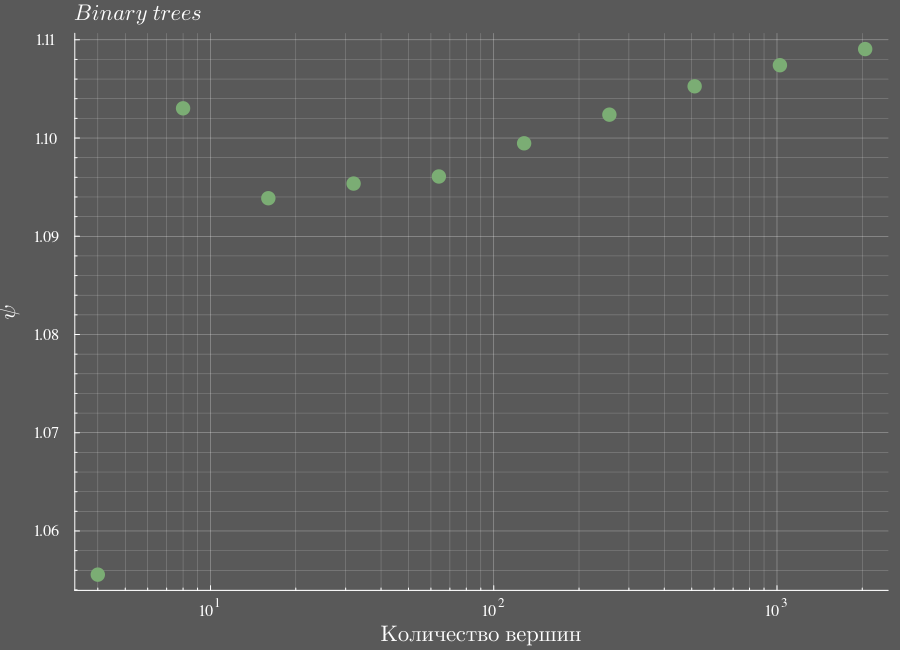

In [20]:
p8 = scatter(2 .^[2:11;], btree1,
    title = L"Binary\ trees",
    titlepos = :left,
    titlefontsize = 15,
    legend = false,
    legendfontsize = 13,
    label = L"n = 10",
    size = (900, 650),
    xaxis = (L"Количество\ вершин", :log),
#     xlims = (1, 1500),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = L"\psi",
#     ylims = (1.08, 1.5),
    markersize = 8,
    background_color = :grey35,
    palette = ColorSchemes.imola10[end-3:end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    markerstrokewidth = 0,
    
    labelfontsize = 15,
    leg_title = L"Усреднение\ по"
)

In [278]:
n_10 = [11,11,11,11,11,11,11,11,11,11,12,13,14,23,24]
n_30 = [37,39,47,48,50,52,55,59,63,78,84,84,86,87,100]
n_100 = [168,169,185,189,192,196,202,213,246,312,350,357,361,362,383]
n_150 = [272,275,288,292,296,300,304,315,326,350,377,546,568,579,596]
n_300 = [482,626,654,659,673,684,704,774,898,1055,1203,1335,1347,1360,1376]

eps = 10. .^[1:15;];

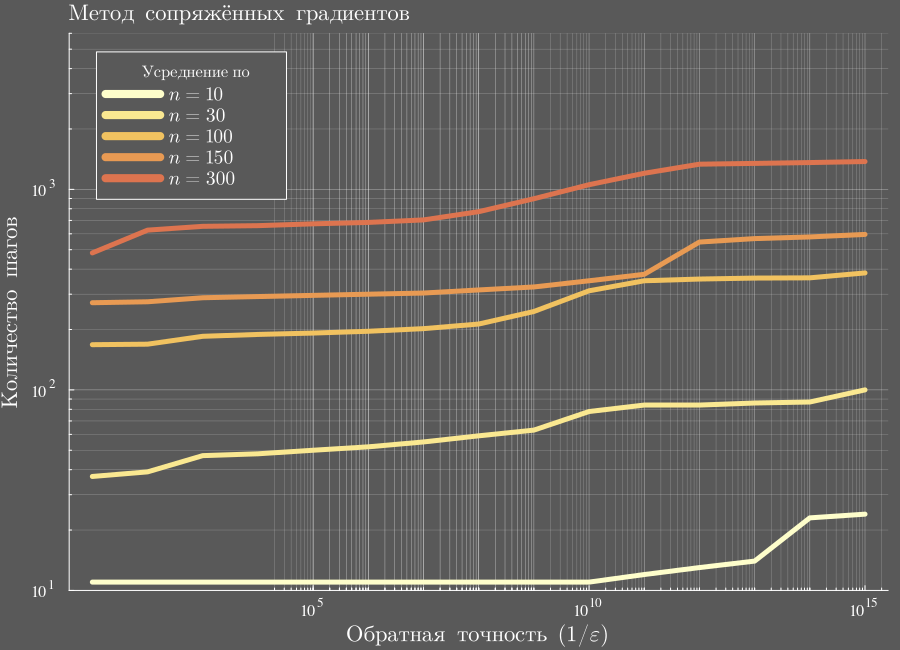

In [293]:
nummeth_plot = plot(eps, n_10,
    title = L"Метод\ \ сопряжённых\ \ градиентов",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topleft,
    legendfontsize = 13,
    label = L"n = 10",
    size = (900, 650),
    xaxis = (L"Обратная\ \ точность\ \ (1/\varepsilon)", :log),
    
    xtickfont = font(10, "Times", :white),
    ytickfont = font(10, "Times", :white),
    
    yaxis = (L"Количество\ \ шагов", :log, (10, 6e3)),
    markersize = 8,
    background_color = :grey35,
    palette = ColorSchemes.lajolla25[1:3:end],
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    markerstrokewidth = 0,
    linewidth = 5,
    
    labelfontsize = 15,
    leg_title = L"Усреднение\ по"
    )
plot!(eps, n_30, label = L"n = 30", markersize = 8, markerstrokewidth = 0, linewidth = 5,)
plot!(   eps, n_100, label = L"n = 100", markersize = 8, markerstrokewidth = 0, linewidth = 5,)
plot!(   eps, n_150, label = L"n = 150", markersize = 8, markerstrokewidth = 0, linewidth = 5,)
plot!(   eps, n_300, label = L"n = 300", markersize = 8, markerstrokewidth = 0, linewidth = 5,)

In [22]:
savefig(p8, "plots/Btrees.svg");

---
# 4. Заключение

[К содержанию](#Содержание:)

Подход к подтверждению/опревержению гипотезы о том, что поиск в ширину в среднем вдвое эффективнее поиска в глубину для неорентированных графов зависит от выбранного способа этот граф создать. Как можно видеть из примеров, её выполнение зависит от установленных параметров генерации. 
* Метод Дороговцева Мендеса — $\large\psi$ приближается скорее к $1.5$
* Модель Модель Эрдёша-Реньи — $\large\psi$ зависит от выбора параметров
* Регулярные графы — гипотеза подтвердилась при степени вершин $k=2$
* Однородные и бинарные деревья - гипотеза не выполняется (примечание: оба алгоритма поиска в среднем показывают себя одинаково при любом количестве вершин).